In [3]:
import os
import copy
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np
from scipy import sparse
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Converting one-hot labels to integers


In [4]:
# Setup the results dictionary
filename = "experiments/results/fig-5.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [5]:
results.groupby(["gene", "model", "num_genes"]).mean()

auc
gene model                                        num_genes          
RPL4 GCN_lay3_chan64_emb32_dropout                50         0.869881
                                                  100        0.898267
                                                  200        0.908238
                                                  300        0.898104
                                                  500        0.899944
                                                  1000       0.878843
                                                  2000       0.848483
                                                  4000       0.803582
                                                  8000       0.757716
                                                  16300      0.692363
     GCN_lay3_chan64_emb32_dropout_pool_hierarchy 50         0.867610
                                                  100        0.867833
                                                  200        0.891159
                                                  300        0.897095
                                                  500        0.892257
                                                  1000       0.895047
                                                  2000       0.903802
                                                  4000       0.900033
                                                  8000       0.849211
                                                  16300      0.754758
     MLP_lay2_chan512                             50         0.851926
                                                  100        0.866958
                                                  200        0.903965
                                                  300        0.899217
                                                  500        0.890447
                                                  1000       0.870222
                                                  2000       0.841495
                                                  4000       0.817189
                                                  8000       0.771471
                                                  16300      0.743100
     MLP_lay2_chan512_dropout                     50         0.854642
                                                  100        0.870548
                                                  200        0.905775
                                                  300        0.901086
                                                  500        0.892302
                                                  1000       0.872937
                                                  2000       0.840946
                                                  4000       0.804799
                                                  8000       0.779974
                                                  16300      0.730087
     SLR_lambda1_l11                              50         0.819934
                                                  100        0.845575
                                                  200        0.888711
                                                  300        0.864568
                                                  500        0.867536
                                                  1000       0.855547
                                                  2000       0.823777
                                                  4000       0.808330
                                                  8000       0.775062
                                                  16300      0.749495

In [9]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB


In [7]:
search_num_genes=[50, 100, 200, 300, 500, 1000, 2000, 4000, 8000, 16000]
test_size=300
search_train_size=[50]
cuda=True
trials=3
search_genes = ["RPL4", "RPL5", "RPS10", "RPS3", "CEBPD", "IL5", "PABPC3", "PSMB10", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]
models = [       
               #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
               GCN(name="GCN_lay3_chan64_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),               
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
               GCN(name="GCN_lay3_chan64_emb32_dropout", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32),
               MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              # MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
#               SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [8]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in models]
columns = ["gene", "model", "num_genes", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(search_genes, model_names, search_num_genes, search_train_size, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 1830
done: 826


In [9]:
def get_every_n(a, n=2):
    for i in range(a.shape[0] // 2):
        yield a[2*i:2*(i+1)]


In [10]:
for row in todo:
    print(row)
    start_time = time.time()
    gene = row["gene"]
    model_name = row["model"]
    seed = row["seed"]
    num_genes = row["num_genes"] if row["num_genes"] < 10000 else 16300
    train_size = row["train_size"]
    model = [copy.deepcopy(model) for model in models if model.name == row["model"]][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "num_genes": num_genes,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
    if num_genes == 16300:
        neighbors = gene_graph.nx_graph
    else:
        neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

    X_train = X_train[list(neighbors.nodes)].copy()
    X_test = X_test[list(neighbors.nodes)].copy()
    X_train[gene] = 1
    X_test[gene] = 1
    adj = np.asarray(nx.to_numpy_matrix(neighbors))
    model.fit(X_train, y_train, adj=adj)
    
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda:
        x_test = x_test.cuda()
    
    y_hat = []
    for chunk in get_every_n(x_test, 10):
        y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    del model
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    results = record_result(results, experiment, filename)
    print(experiment)


{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16000, 'train_size': 50, 'seed': 0}
setup layers took: 4.280272483825684
epoch: 0 0.276655912399292
epoch: 1 0.21334314346313477
epoch: 2 0.2126941680908203
epoch: 3 0.21340703964233398
epoch: 4 0.21262836456298828
epoch: 5 0.2125699520111084
epoch: 6 0.21256613731384277
epoch: 7 0.2125544548034668
epoch: 8 0.2132112979888916
epoch: 9 0.2129366397857666
epoch: 10 0.21275758743286133
epoch: 11 0.21277403831481934
epoch: 12 0.21320867538452148
epoch: 13 0.21317625045776367
epoch: 14 0.21323347091674805
epoch: 15 0.2133016586303711
total train time:10.695869445800781 for epochs: 16
{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16300, 'train_size': 50, 'seed': 0, 'auc': 0.7030804843304843, 'time_elapsed': '21.549554347991943'}
{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16000, 'train_size': 50, 'seed': 1}
setup layers too

KeyboardInterrupt: 

In [1]:
results

NameError: name 'results' is not defined

In [10]:
0 % 1

0

In [10]:
results

,auc,gene,model,num_genes,seed,train_size,time_elapsed
0,0.575046,RPL4,GCN_lay3_chan64_emb32_dropout,50,0,50,35.51251173019409
1,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,50,1,50,6.390526533126831
2,0.544952,RPL4,GCN_lay3_chan64_emb32_dropout,50,2,50,3.7114007472991943
3,0.500721,RPL4,GCN_lay3_chan64_emb32_dropout,50,3,50,3.427546977996826
4,0.497917,RPL4,GCN_lay3_chan64_emb32_dropout,50,4,50,3.657351016998291
5,0.466869,RPL4,GCN_lay3_chan64_emb32_dropout,100,0,50,3.0078303813934326
6,0.469764,RPL4,GCN_lay3_chan64_emb32_dropout,100,1,50,2.4217426776885986
7,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,100,2,50,4.3778393268585205
8,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,100,3,50,4.056507587432861
9,0.476294,RPL4,GCN_lay3_chan64_emb32_dropout,100,4,50,2.8931021690368652


In [7]:
row = todo[0]
print(row)
start_time = time.time()
gene = row["gene"]
model_name = row["model"]
seed = row["seed"]
num_genes = 2000
train_size = row["train_size"]

model = [x for x in models if x.name == model_name][0]

experiment = {
    "gene": gene,
    "model": model.name,
    "num_genes": num_genes,
    "train_size": train_size,
    "seed": seed,
}

dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

X_train = X_train[list(neighbors.nodes)].copy()
X_test = X_test[list(neighbors.nodes)].copy()
X_train[gene] = 1
X_test[gene] = 1
adj = np.asarray(nx.to_numpy_matrix(neighbors))


{'model': 'GCN_lay1_chan64_emb32_dropout_agg', 'seed': 0, 'num_genes': 4000, 'gene': 'IL5', 'train_size': 50}


206


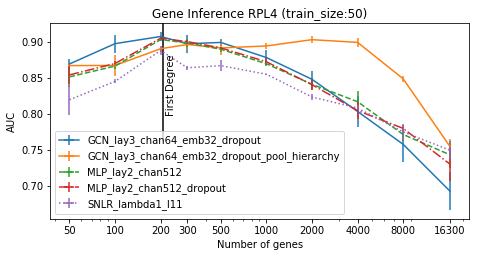

In [10]:

for plot_gene in ["RPL4"]:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print(fd)
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()